### Importation des bibliothèques

In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt

from skimage import io, color, data, transform
from sklearn.datasets import fetch_lfw_people
from skimage.feature import hog

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.image import PatchExtractor

from itertools import chain  

import joblib

from TIPEutils import sliding_window

### Ouverture des hard negatives examples

In [15]:
hne = np.load('hne3.npy')
print(hne)

[[[0.24630943 0.24747171 0.22073932 ... 0.16764811 0.16295249 0.16315665]
  [0.24630943 0.24747171 0.22073932 ... 0.16764811 0.16295249 0.16315665]
  [0.21571973 0.21654826 0.19749213 ... 0.19456473 0.1859618  0.18633584]
  ...
  [0.04663485 0.04734976 0.03090673 ... 0.07542259 0.0595903  0.06027866]
  [0.05544674 0.05567291 0.05047118 ... 0.04561089 0.0441716  0.04423417]
  [0.05544674 0.05567291 0.05047118 ... 0.04561089 0.0441716  0.04423417]]

 [[0.35857176 0.3257549  0.2870898  ... 0.34210078 0.37345843 0.41013647]
  [0.3681349  0.32804039 0.28208275 ... 0.11473216 0.12619922 0.14802431]
  [0.37517529 0.33732078 0.2907898  ... 0.22742392 0.21310667 0.20077647]
  ...
  [0.07567137 0.07235294 0.05666667 ... 0.59919725 0.60311882 0.60311882]
  [0.07369922 0.07009804 0.05833333 ... 0.60311882 0.60311882 0.60311882]
  [0.05967961 0.07176471 0.07568627 ... 0.62272667 0.62272667 0.62272667]]

 [[0.42371784 0.41897184 0.40756535 ... 0.46493339 0.47514019 0.4857431 ]
  [0.42269743 0.430364

### Chargement des données d'entraînement

<ipython-input-16-0fa095b98f10>:8: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  images = [color.rgb2gray(getattr(data, name)())


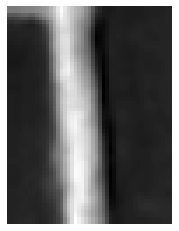

In [16]:
faces = fetch_lfw_people()             # Visages du dataset LFW
positive_patches = faces.images        # Ces images seront nos "zones positives"

# Pour les "zones négatives", on prend des images de thémes variés qui ne contiennent pas de visage
imgs_to_use = ['brick', 'text', 'moon', 'grass', 'gravel',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field', 'cell']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    ''' Extrait des patches d'une image
    '''
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negatives_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])

# On ajoute les hard negatives examples
negatives_patches = np.vstack((negatives_patches, hne))

fig, ax = plt.subplots()
ax.imshow(negatives_patches[50], cmap='gray')
ax.axis('off')

X_train = np.array([hog(img)
                    for img in chain(positive_patches,
                                     negatives_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1     # les positifs auront le label 1, les négatifs 0

### à entrainer

In [17]:
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

/Users/julesdupont/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/julesdupont/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/julesdupont/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/julesdupont/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/julesdupont/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.p

0.9917360406091369

In [18]:
grid.best_params_

{'C': 1.0}

In [19]:
model = grid.best_estimator_
# model.fit(X_train, y_train)    pas besoin car déjà refit ??

### Export du modèle

In [20]:
filename = 'model_04.sav'
joblib.dump(model, filename, compress=9)


['model_04.sav']

In [5]:
[4, 5] + [6]

[4, 5, 6]